# Génération de MIDI avec le Music Transformer

In [22]:
tokenizer_path = "../src/data/processed/tokenizer"

In [21]:
# Imports
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pickle

sys.path.append(str(Path.cwd().parent / 'src'))

from models.lightning_module import MusicTransformerLightning
from miditok import REMI

# Config
%matplotlib inline

## 1. Chargement du Modèle Entraîné

In [ ]:
# Chemins
CHECKPOINT_PATH = Path("../src/models/music-transformer-final.ckpt")
TOKENIZER_PATH = Path("../src/data/processed/tokenizer")
OUTPUT_DIR = Path("../generated_music")

# On crée le dossier de sortie
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [25]:
# On charge le modèle depuis le checkpoint

model = MusicTransformerLightning.load_from_checkpoint(
    checkpoint_path=str(CHECKPOINT_PATH),
    map_location='cuda' if torch.cuda.is_available() else 'cpu'
)

# Mettre en mode évaluation
model.eval()
model.freeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Modèle chargé et prêt")

num_params = sum(p.numel() for p in model.parameters())
print(f"Paramètres: {num_params:,}")
print(f"Vocabulaire: {model.hparams.vocab_size}")

# Vérification
if num_params == 0:
    print("Problème de chargement, aucun paramètre")

Modèle chargé et prêt
Paramètres: 19,378,629
Vocabulaire: 453


## 2. Chargement du Tokenizer

In [83]:
# On charge le tokenizer REMI

from miditok import REMI, TokenizerConfig

# Recréer la config SANS multi-vocab
# config = TokenizerConfig(
#     num_velocities=32,
#     use_chords=False,
#     use_rests=False,
#     use_tempos=True,
#     use_time_signatures=True,
#     use_programs=False,
#     beat_res={(0, 12): 8},
#     nb_velocities=32,
#     one_token_stream_for_programs=True
# )
config = TokenizerConfig(
    num_velocities=32,           # 32 niveaux de vélocité (0-127 → 32 bins)
    use_chords=False,            # Pas de détection d'accords (on veut les notes individuelles)
    use_rests=True,              # Pas de silences explicites (géré par time_shift)
    use_tempos=True,             # Conserver les tempos
    use_time_signatures=True,    # Conserver les signatures temporelles
    use_programs=False,          # Pas besoin (piano uniquement dans MAESTRO)
    beat_res={(0, 12): 8},      # Résolution temporelle
    nb_velocities=32,
    one_token_stream_for_programs=True
)
# Créer le tokenizer avec cette config
tokenizer = REMI(config)

# Charger le vocabulaire depuis le dossier
tokenizer_path = TOKENIZER_PATH / "tokenizer.json"
tokenizer = REMI(params=str(tokenizer_path))

print(f"Tokenizer chargé")
print(f"Vocabulaire: {len(tokenizer)} tokens")
print(f"Format I/O: {tokenizer.io_format}")
print(f"Multi-voc: {tokenizer.is_multi_voc}")

Tokenizer chargé
Vocabulaire: 453 tokens
Format I/O: ('I', 'T')
Multi-voc: False


C:\Users\jerem\AppData\Local\Temp\ipykernel_20080\1419404310.py:17: UserWarning: Argument nb_velocities has been renamed num_velocities, you should consider to updateyour code with this new argument name.
  config = TokenizerConfig(


## 3. Création d'un Prompt de Départ

In [85]:
# On charge les séquences de validation
with open("../src/data/processed/validation_sequences.pkl", 'rb') as f:
    val_sequences = pickle.load(f)

# On prend une séquence aléatoire
seed_sequence = val_sequences[np.random.randint(0, len(val_sequences))]

# On prends les 128 premiers tokens comme prompt de départ
prompt_length = 128
prompt_tokens = seed_sequence[:prompt_length]

print(f"Prompt créé")
print(f"Longueur: {len(prompt_tokens)} tokens")
print(f"Premiers tokens: {prompt_tokens[:20]}")

# Convertir en tensor
prompt_tensor = torch.tensor([prompt_tokens], dtype=torch.long, device=device)
print(f"Tensor shape: {prompt_tensor.shape}")

Prompt créé
Longueur: 128 tokens
Premiers tokens: [51, 102, 126, 54, 106, 127, 35, 98, 126, 241, 28, 109, 133, 47, 107, 129, 56, 109, 133, 247]
Tensor shape: torch.Size([1, 128])


## 4. Génération de Musique


In [86]:
# Configuration des hyperparamètres de génération
GENERATION_CONFIG = {
    'max_length': 512,       # Longueur de la génération
    'temperature': 0.8,      # Créativité (0.5-1.5)
    'top_k': 50,             # Top-k sampling
    'top_p': 0.95            # Nucleus sampling
}

print("Configuration des hyperparamètres de génération:")
for key, value in GENERATION_CONFIG.items():
    print(f"  {key:15s}: {value}")

Configuration des hyperparamètres de génération:
  max_length     : 512
  temperature    : 0.8
  top_k          : 50
  top_p          : 0.95


In [87]:
# Et on génère

with torch.no_grad():
    generated_tokens = model.generate(
        prompt=prompt_tensor,
        max_length=GENERATION_CONFIG['max_length'],
        temperature=GENERATION_CONFIG['temperature'],
        top_k=GENERATION_CONFIG['top_k'],
        top_p=GENERATION_CONFIG['top_p']
    )

# Convertir en liste
generated_tokens = generated_tokens[0].cpu().tolist()

print(f"Génération terminée !")
print(f"Longueur totale: {len(generated_tokens)} tokens")
print(f"Prompt: {prompt_length} tokens")
print(f"Générés: {len(generated_tokens) - prompt_length} tokens")

Génération terminée !
Longueur totale: 512 tokens
Prompt: 128 tokens
Générés: 384 tokens


## 5. Conversion en MIDI

Maintenant on convertit les tokens en fichier MIDI avec miditok.

In [88]:
import os
from pathlib import Path

# Génération principale

existing_folders = [d for d in OUTPUT_DIR.iterdir() if d.is_dir() and d.name.startswith('Music_')]
if existing_folders:
    last_num = max([int(f.name.split('_')[1]) for f in existing_folders])
    next_num = last_num + 1
else:
    next_num = 1

# Créer le dossier pour cette génération
music_folder = OUTPUT_DIR / f"Music_{next_num:03d}"
music_folder.mkdir(parents=True, exist_ok=True)

print(f"Dossier créé: {music_folder.name}\n")

# Conversion tokens en MIDI
try:
    # Wrappe les tokens pour le format ('I', 'T')
    generated_tokens_wrapped = [generated_tokens]
    
    # On décode en MIDI
    midi = tokenizer.decode(generated_tokens_wrapped)
    
    # Sauvegarder dans le dossier Music_XXX
    output_path = music_folder / "main.mid"
    midi.dump_midi(str(output_path))
    
    print(f"MIDI principal créé")
    print(f"Fichier: {output_path}")
    
except Exception as e:
    print(f"Erreur: {e}")
    import traceback
    print("Traceback complet:")
    traceback.print_exc()

Dossier créé: Music_019

MIDI principal créé
Fichier: ..\generated_music\Music_019\main.mid


## 6. Visualisation

In [89]:
# On analyse les tokens générés
from collections import Counter

# Séparation prompt et génération
prompt_part = generated_tokens[:prompt_length]
generated_part = generated_tokens[prompt_length:]

# On compte les tokens
token_counts = Counter(generated_part)
most_common = token_counts.most_common(10)

print("Analyse des tokens générés:")
print("Top 10 tokens les plus fréquents:")
for token_id, count in most_common:
    try:
        token_name = tokenizer.vocab[token_id]
    except:
        token_name = f"Token_{token_id}"
    percentage = (count / len(generated_part)) * 100
    print(f"    {token_id:5d} ({token_name}) : {count:4d} fois ({percentage:.1f}%)")

Analyse des tokens générés:
Top 10 tokens les plus fréquents:
      129 (Token_129) :   37 fois (9.6%)
      130 (Token_130) :   31 fois (8.1%)
      128 (Token_128) :   20 fois (5.2%)
      110 (Token_110) :   19 fois (4.9%)
      111 (Token_111) :   17 fois (4.4%)
       37 (Token_37) :   16 fois (4.2%)
       38 (Token_38) :   16 fois (4.2%)
       42 (Token_42) :   16 fois (4.2%)
      112 (Token_112) :   15 fois (3.9%)
       54 (Token_54) :   15 fois (3.9%)


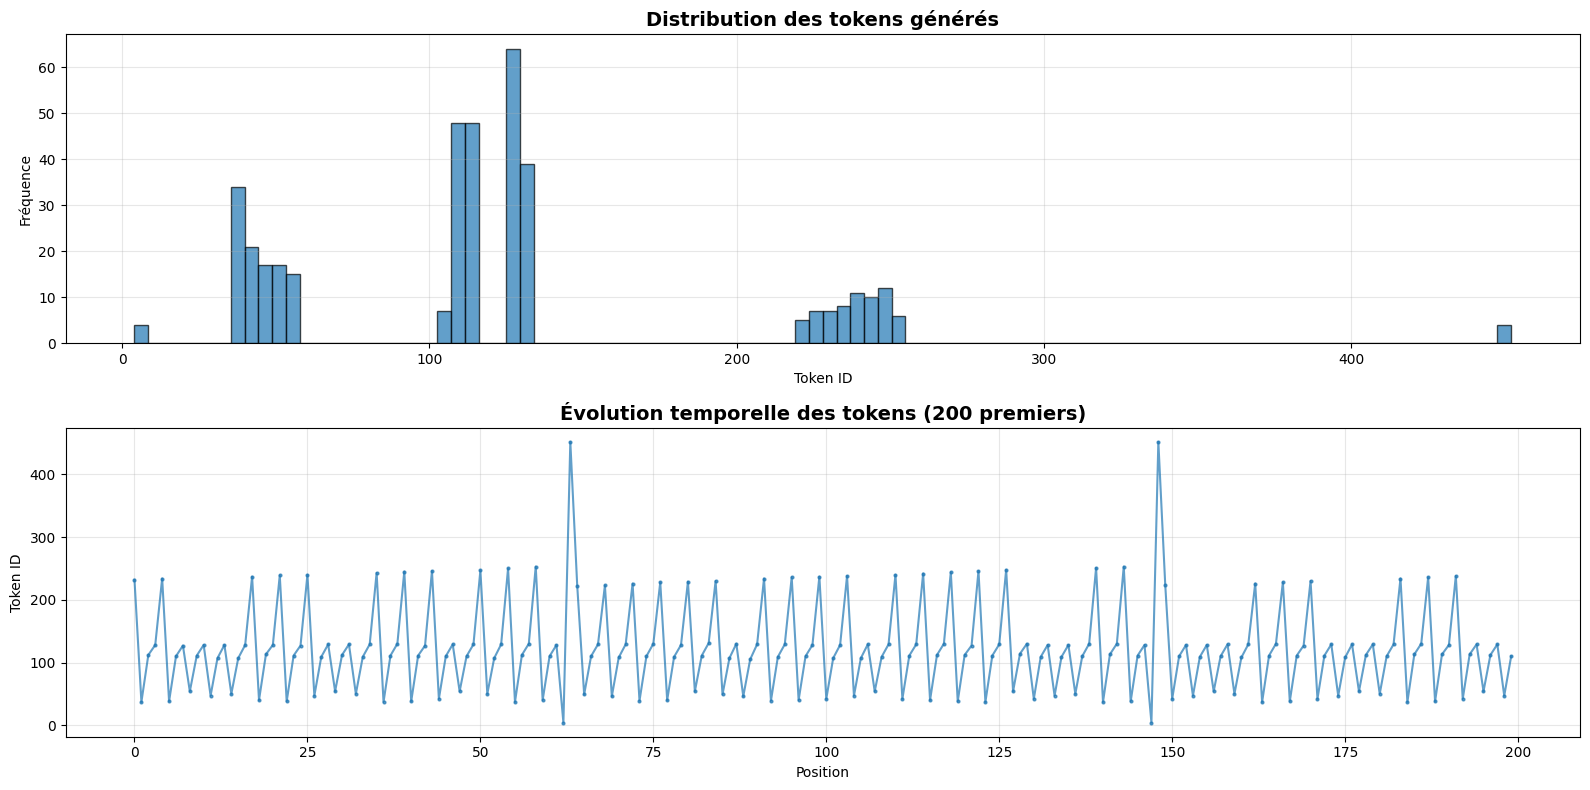

✓ Visualisation sauvegardée


In [90]:
# Visualisation de la séquence
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# 1. Distribution des tokens
axes[0].hist(generated_part, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution des tokens générés', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Token ID')
axes[0].set_ylabel('Fréquence')
axes[0].grid(True, alpha=0.3)

# 2. Séquence temporelle (premiers 200 tokens)
sample_length = min(200, len(generated_part))
axes[1].plot(range(sample_length), generated_part[:sample_length], marker='o', markersize=2, alpha=0.7)
axes[1].set_title('Évolution temporelle des tokens (200 premiers)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Token ID')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'token_analysis.png', dpi=150, bbox_inches='tight')

plt.show()

print("✓ Visualisation sauvegardée")

## 7. Génération Multiple

Générons plusieurs variations avec différents paramètres pour comparer.

In [91]:

# Génération des variations de créativité du modèle

configs = [
    {'name': 'conservative', 'temperature': 0.5, 'top_k': 20, 'top_p': 0.9},
    {'name': 'balanced', 'temperature': 0.8, 'top_k': 50, 'top_p': 0.95},
    {'name': 'creative', 'temperature': 1.2, 'top_k': 100, 'top_p': 0.95},
]

for i, config in enumerate(configs, 1):
    print(f"  Variation {i}: {config['name'].capitalize()}")
    print(f"    Temperature: {config['temperature']}, Top-k: {config['top_k']}, Top-p: {config['top_p']}")
    
    # Génération
    with torch.no_grad():
        generated = model.generate(
            prompt=prompt_tensor,
            max_length=512,
            temperature=config['temperature'],
            top_k=config['top_k'],
            top_p=config['top_p']
        )
    
    tokens = generated[0].cpu().tolist()
    
    # Conversion en MIDI
    try:
        tokens_wrapped = [tokens]
        midi = tokenizer.decode(tokens_wrapped)
        output_path = music_folder / f"{config['name']}.mid"
        midi.dump_midi(str(output_path))
        print(f"Sauvegardé: {output_path.name}")
    except Exception as e:
        print(f"Erreur: {e}")
    
    print()

print("\n")
print(f"Génération complète terminée !")
print(f"Dossier: {music_folder.name}")
print(f"Fichiers créés:")
print(f"1. main.mid (température: 0.8)")
print(f"2. conservative.mid (température: 0.5)")
print(f"3. balanced.mid (température: 0.8)")
print(f"4. creative.mid (température: 1.2)")

  Variation 1: Conservative
    Temperature: 0.5, Top-k: 20, Top-p: 0.9
Sauvegardé: conservative.mid

  Variation 2: Balanced
    Temperature: 0.8, Top-k: 50, Top-p: 0.95
Sauvegardé: balanced.mid

  Variation 3: Creative
    Temperature: 1.2, Top-k: 100, Top-p: 0.95
Sauvegardé: creative.mid



Génération complète terminée !
Dossier: Music_019
Fichiers créés:
1. main.mid (température: 0.8)
2. conservative.mid (température: 0.5)
3. balanced.mid (température: 0.8)
4. creative.mid (température: 1.2)
